In [1]:
import pickle
from pathlib import Path

bolus_path = Path('/Users/davidspector/Home/Stanford/QuantUS Projects/TTC-Analysis/bolus_features_by_mouse.pkl')
molecular_path = Path('/Users/davidspector/Home/Stanford/QuantUS Projects/TTC-Analysis/molecular_features_by_mouse.pkl')

with open(bolus_path, 'rb') as f:
    bolus_features_by_mouse = pickle.load(f)
with open(molecular_path, 'rb') as f:
    molecular_features_by_mouse = pickle.load(f)

In [2]:
mouse_names = ['m908', 'm946', 'm907', 'm904', 'm947', 'm935', 'm939', 'm933', 'm948', 'm943', 'm940']

In [3]:
import numpy as np

len(bolus_features_by_mouse), len(molecular_features_by_mouse), len(mouse_names) # Number of mice

(11, 11, 11)

In [4]:
import yaml
import pandas as pd

yaml_path = Path('/Users/davidspector/Home/Stanford/QuantUS Projects/TTC-Analysis/data-organization.yml')
data_organization = yaml.safe_load(yaml_path.read_text())

df = pd.DataFrame(columns=['mouse', 'day', 'bolus-features', 'molecular-features', 'group', 'responder'])
for i, mouse in enumerate(mouse_names):
    for j in range(len(bolus_features_by_mouse[i])):
        bolus_features = bolus_features_by_mouse[i][j]
        molecular_features = molecular_features_by_mouse[i][j]
        group = data_organization[mouse]
        responder = group == 'LSAV'
        df = pd.concat((df, pd.DataFrame({'mouse': [mouse], 'day': [j], 'bolus-features': [bolus_features], 'molecular-features': [molecular_features],
                                          'group': [group], 'responder': [responder]})), ignore_index=True)

In [5]:
features = list(df.loc[0, 'molecular-features'][0].keys())
features[11]

'diagnostics_Image-original_Mean'

In [6]:
def smooth_curve(data, window_size=5):
    """
    Smooth a curve using a moving average filter to remove noise
    
    Args:
        data: List or array of values to smooth
        window_size: Size of moving average window (default 5)
    Returns:
        Smoothed data array
    """
    kernel = np.ones(window_size) / window_size
    return np.convolve(data, kernel, mode='valid')

def remove_outliers(data, threshold=2, window_size=10):
    """
    Remove outliers from data using z-score method with sliding window
    
    Args:
        data: List or array of values to process
        threshold: Z-score threshold for outlier detection (default 2)
        window_size: Size of sliding window for local statistics (default 20)
    Returns:
        Data array with outliers replaced by local mean
    """
    data = np.array(data)
    cleaned_data = data.copy()
    
    # Use sliding window to detect and replace outliers
    for i in range(len(data)):
        # Calculate window boundaries
        window_start = max(0, i - window_size//2)
        window_end = min(len(data), i + window_size//2)
        
        # Get window excluding current point
        window = np.concatenate([data[window_start:i], data[i+1:window_end]])
        
        # Calculate z-score using local window statistics
        z_score = abs((data[i] - np.mean(window)) / np.std(window))
        
        # Replace outliers with local mean
        if z_score > threshold:
            cleaned_data[i] = np.mean(window)
            
    return cleaned_data

In [7]:
molecular_vals = df.loc[1, 'molecular-features']


In [39]:
feature = 'original_firstorder_Entropy'
bolus_feature_vals = []; molecular_feature_vals = []
for j in range(startIx, min(endIx, len(bolus_vals))):
    try:
        bolus_feature_vals.append(bolus_vals[j][feature])
    except KeyError:
        bolus_feature_vals.append(bolus_feature_vals[-1])
    try:
        molecular_feature_vals.append(molecular_vals[j][feature])
    except KeyError:
        molecular_feature_vals.append(molecular_feature_vals[-1])
        
try:    
    smoothed_bolus_vals = smooth_curve(bolus_feature_vals)
except ValueError:
    print("Skipping", feature)
smoothed_molecular_vals = smooth_curve(molecular_feature_vals)
cleaned_bolus = remove_outliers(smoothed_bolus_vals)
cleaned_molecular = remove_outliers(smoothed_molecular_vals)

In [41]:
time_points = np.arange(len(cleaned_molecular[peak_idx:]))
molecular_log_values = np.log(cleaned_molecular[peak_idx:])
bolus_log_values = np.log(cleaned_bolus[peak_idx:])

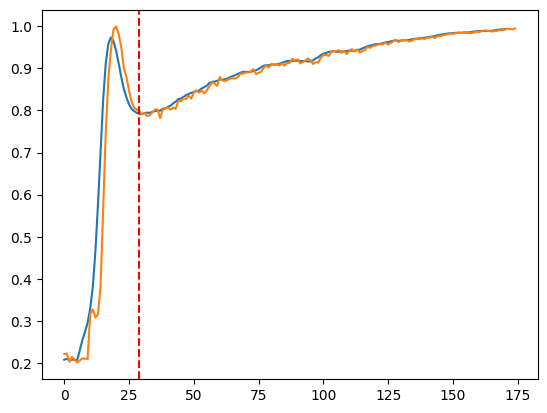

In [40]:
# peak_idx = np.argmax(cleaned_molecular)

plt.plot(cleaned_molecular)
plt.plot(molecular_feature_vals)

plt.axvline(x=peak_idx, color='r', linestyle='--', label='Peak')

In [8]:
import matplotlib.pyplot as plt

startIx = 0; endIx = 350

# Create a new dataframe to store washout rates
stats_df = pd.DataFrame(columns=['mouse', 'day', 'feature', 'bolus_washout_rate', 'molecular_washout_rate', 'group', 'responder',
                                        'min_bolus', 'max_bolus', 'mean_bolus', 'median_bolus', 'min_molecular', 'max_molecular', 'mean_molecular', 'median_molecular',
                                        'std_bolus', 'std_molecular'])

# Calculate washout rate for each curve
for idx, row in df.iterrows():  
    
    for featureIx in range(11, len(features)):
        feature = features[featureIx]
        bolus_vals = df.loc[idx, 'bolus-features'] 
        molecular_vals = df.loc[idx, 'molecular-features']
        
        bolus_feature_vals = []; molecular_feature_vals = []
        for j in range(startIx, min(endIx, len(bolus_vals))):
            try:
                bolus_feature_vals.append(bolus_vals[j][feature])
            except KeyError:
                bolus_feature_vals.append(bolus_feature_vals[-1])
            try:
                molecular_feature_vals.append(molecular_vals[j][feature])
            except KeyError:
                molecular_feature_vals.append(molecular_feature_vals[-1])
                
        
        # Remove outliers
        try:    
            smoothed_bolus_vals = smooth_curve(bolus_feature_vals)
        except ValueError:
            print("Skipping", feature)
            continue
        smoothed_molecular_vals = smooth_curve(molecular_feature_vals)
        cleaned_bolus = remove_outliers(smoothed_bolus_vals)
        cleaned_molecular = remove_outliers(smoothed_molecular_vals)
        
        # Find the peak index
        if featureIx == 11:
            peak_idx = np.argmax(molecular_feature_vals)
        
        # Calculate slope of decay after peak (washout rate)
        # Using linear regression on log-transformed values
        time_points = np.arange(len(cleaned_molecular[peak_idx:]))
        molecular_log_values = cleaned_molecular[peak_idx:]
        bolus_log_values = cleaned_bolus[peak_idx:]
        
        # Fit line to log-transformed values
        try:
            molecular_slope, _ = np.polyfit(time_points, molecular_log_values, 1)
            bolus_slope, _ = np.polyfit(time_points, bolus_log_values, 1)
        except:
            print(idx)
            print("FEATURE", feature)
            print(molecular_log_values)
            print(molecular_vals)
            continue
        
        # Calculate additional statistics
        min_bolus = np.min(cleaned_bolus)
        max_bolus = np.max(cleaned_bolus)
        mean_bolus = np.mean(cleaned_bolus)
        median_bolus = np.median(cleaned_bolus)
        std_bolus = np.std(cleaned_bolus)
        
        min_molecular = np.min(cleaned_molecular)
        max_molecular = np.max(cleaned_molecular)
        mean_molecular = np.mean(cleaned_molecular)
        median_molecular = np.median(cleaned_molecular)
        std_molecular = np.std(cleaned_molecular)
        
        # Store results
        stats_df = pd.concat((stats_df, 
                                    pd.DataFrame({'mouse': [row['mouse']], 
                                                'day': [row['day']], 
                                                'feature': [feature],
                                                'bolus_washout_rate': [bolus_slope],
                                                'molecular_washout_rate': [molecular_slope],
                                                'group': [row['group']],
                                                'responder': [row['responder']],
                                                'min_bolus': [min_bolus],
                                                'max_bolus': [max_bolus], 
                                                'mean_bolus': [mean_bolus],
                                                'median_bolus': [median_bolus],
                                                'min_molecular': [min_molecular],
                                                'max_molecular': [max_molecular],
                                                'mean_molecular': [mean_molecular],
                                                'median_molecular': [median_molecular],
                                                'std_bolus': [std_bolus],
                                                'std_molecular': [std_molecular]})),
                                    ignore_index=True)

/var/folders/5z/myjw1nc12n3g808z31wz0kt80000gn/T/ipykernel_26899/2623914470.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  stats_df = pd.concat((stats_df,
/var/folders/5z/myjw1nc12n3g808z31wz0kt80000gn/T/ipykernel_26899/2160689499.py:38: RuntimeWarning: invalid value encountered in scalar divide
  z_score = abs((data[i] - np.mean(window)) / np.std(window))


Skipping diagnostics_Mask-original_Hash
Skipping diagnostics_Mask-original_Spacing
Skipping diagnostics_Mask-original_Size
Skipping diagnostics_Mask-original_BoundingBox
Skipping diagnostics_Mask-original_CenterOfMassIndex
Skipping diagnostics_Mask-original_CenterOfMass
Skipping diagnostics_Mask-original_Hash
Skipping diagnostics_Mask-original_Spacing
Skipping diagnostics_Mask-original_Size
Skipping diagnostics_Mask-original_BoundingBox
Skipping diagnostics_Mask-original_CenterOfMassIndex
Skipping diagnostics_Mask-original_CenterOfMass


/var/folders/5z/myjw1nc12n3g808z31wz0kt80000gn/T/ipykernel_26899/2160689499.py:38: RuntimeWarning: divide by zero encountered in scalar divide
  z_score = abs((data[i] - np.mean(window)) / np.std(window))


Skipping diagnostics_Mask-original_Hash
Skipping diagnostics_Mask-original_Spacing
Skipping diagnostics_Mask-original_Size
Skipping diagnostics_Mask-original_BoundingBox
Skipping diagnostics_Mask-original_CenterOfMassIndex
Skipping diagnostics_Mask-original_CenterOfMass
Skipping diagnostics_Mask-original_Hash
Skipping diagnostics_Mask-original_Spacing
Skipping diagnostics_Mask-original_Size
Skipping diagnostics_Mask-original_BoundingBox
Skipping diagnostics_Mask-original_CenterOfMassIndex
Skipping diagnostics_Mask-original_CenterOfMass
Skipping diagnostics_Mask-original_Hash
Skipping diagnostics_Mask-original_Spacing
Skipping diagnostics_Mask-original_Size
Skipping diagnostics_Mask-original_BoundingBox
Skipping diagnostics_Mask-original_CenterOfMassIndex
Skipping diagnostics_Mask-original_CenterOfMass
Skipping diagnostics_Mask-original_Hash
Skipping diagnostics_Mask-original_Spacing
Skipping diagnostics_Mask-original_Size
Skipping diagnostics_Mask-original_BoundingBox
Skipping diagnost

In [9]:
stats_df.tail()

,mouse,day,feature,bolus_washout_rate,molecular_washout_rate,group,responder,min_bolus,max_bolus,mean_bolus,median_bolus,min_molecular,max_molecular,mean_molecular,median_molecular,std_bolus,std_molecular
2459,m940,1,original_ngtdm_Busyness,-6.309391,3.451000e+01,LSCTRL,False,321.714467,12088.586744,1273.886002,1003.204222,549.145537,803405.894414,103684.243813,39254.042898,1675.376238,171681.727852
2460,m940,1,original_ngtdm_Coarseness,0.000007,4.471568e-08,LSCTRL,False,0.000113,400000.000066,4385.965697,0.000696,0.000062,0.000716,0.000102,0.000065,35804.090497,0.000125
2461,m940,1,original_ngtdm_Complexity,-0.000202,-1.053356e-04,LSCTRL,False,0.026383,0.317330,0.076514,0.071854,0.015266,0.167621,0.146649,0.159110,0.048685,0.036994
2462,m940,1,original_ngtdm_Contrast,-0.000002,-1.010430e-04,LSCTRL,False,0.000543,0.078322,0.008306,0.004913,0.000200,0.040289,0.032026,0.035258,0.013051,0.010185
2463,m940,1,original_ngtdm_Strength,0.000007,4.526370e-08,LSCTRL,False,0.000044,0.001660,0.000783,0.000685,0.000062,0.000717,0.000102,0.000065,0.000329,0.000125


In [10]:
# Create a DataFrame for day differences
day_0_data = stats_df[stats_df['day'] == 0].copy()
day_1_data = stats_df[stats_df['day'] == 1].copy()

# Ensure we're comparing the same mice and features
comparison_cols = ['mouse', 'feature']
diff_df = day_1_data.merge(day_0_data, on=comparison_cols, suffixes=('_day1', '_day0'))

# Calculate differences for all numeric columns
numeric_cols = ['bolus_washout_rate', 'molecular_washout_rate', 
                'min_bolus', 'max_bolus', 'mean_bolus', 'median_bolus',
                'min_molecular', 'max_molecular', 'mean_molecular', 'median_molecular',
                'std_bolus', 'std_molecular']

for col in numeric_cols:
    diff_df[f'{col}_diff'] = diff_df[f'{col}_day1'] - diff_df[f'{col}_day0']

# Keep only relevant columns
keep_cols = ['mouse', 'feature', 'group_day1', 'responder_day1'] + [f'{col}_diff' for col in numeric_cols]
diff_df = diff_df[keep_cols]

# Rename columns to be cleaner
diff_df = diff_df.rename(columns={'group_day1': 'group', 'responder_day1': 'responder'})


In [11]:
diff_df.tail()

,mouse,feature,group,responder,bolus_washout_rate_diff,molecular_washout_rate_diff,min_bolus_diff,max_bolus_diff,mean_bolus_diff,median_bolus_diff,min_molecular_diff,max_molecular_diff,mean_molecular_diff,median_molecular_diff,std_bolus_diff,std_molecular_diff
1227,m940,original_ngtdm_Busyness,LSCTRL,False,1.540772,2.277365e+03,-157.713642,2781.483534,-416.918457,-399.365413,109.988527,-1.413569e+06,-25534.964878,5577.909961,360.380281,-179375.903266
1228,m940,original_ngtdm_Coarseness,LSCTRL,False,0.000005,-4.636520e-09,-0.000023,-0.000016,-51.904674,0.000169,-0.000027,-3.988366e-04,-0.000054,-0.000027,-208.037387,-0.000069
1229,m940,original_ngtdm_Complexity,LSCTRL,False,0.000133,-4.076999e-05,-0.017433,-0.081640,-0.036583,-0.032261,0.005054,3.877379e-02,0.035104,0.035918,-0.004604,0.005269
1230,m940,original_ngtdm_Contrast,LSCTRL,False,0.000072,-3.375358e-05,-0.001606,-0.020914,-0.005191,-0.005288,0.000051,1.030153e-02,0.008850,0.009387,-0.003014,0.001970
1231,m940,original_ngtdm_Strength,LSCTRL,False,0.000005,-4.478889e-09,-0.000038,0.000264,0.000233,0.000158,-0.000027,-4.006026e-04,-0.000054,-0.000027,0.000164,-0.000070


# Manual Investigations

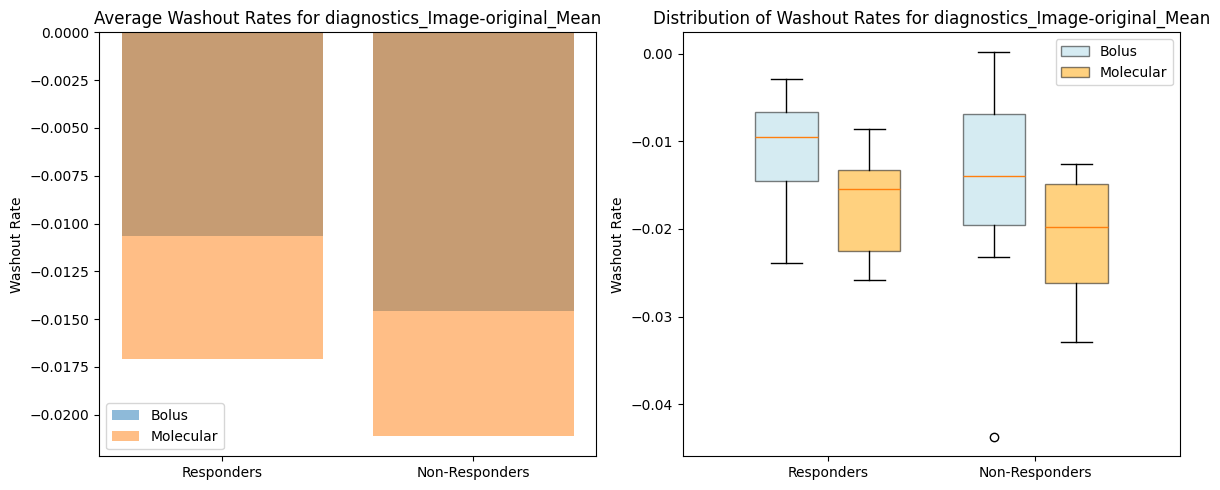

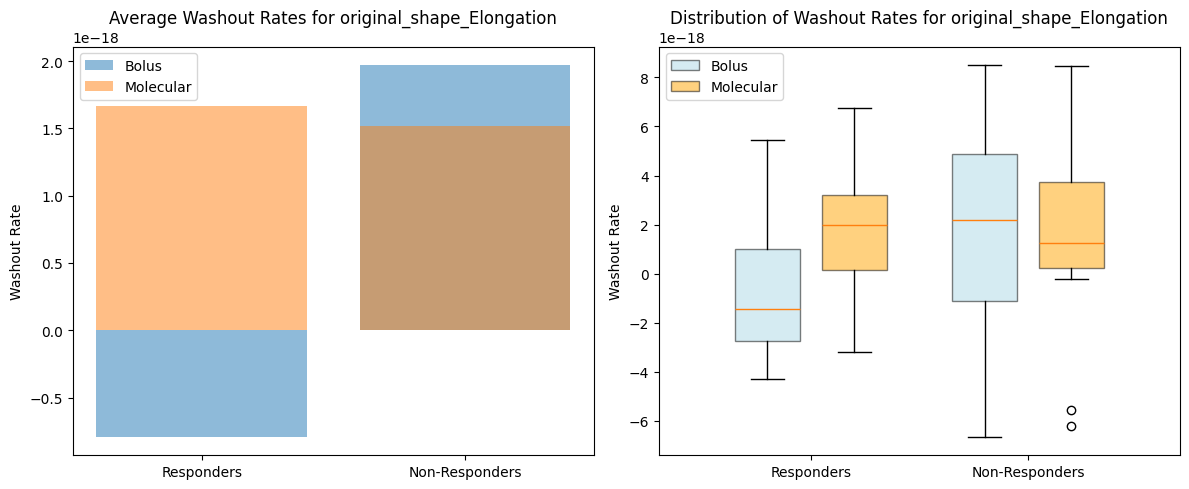

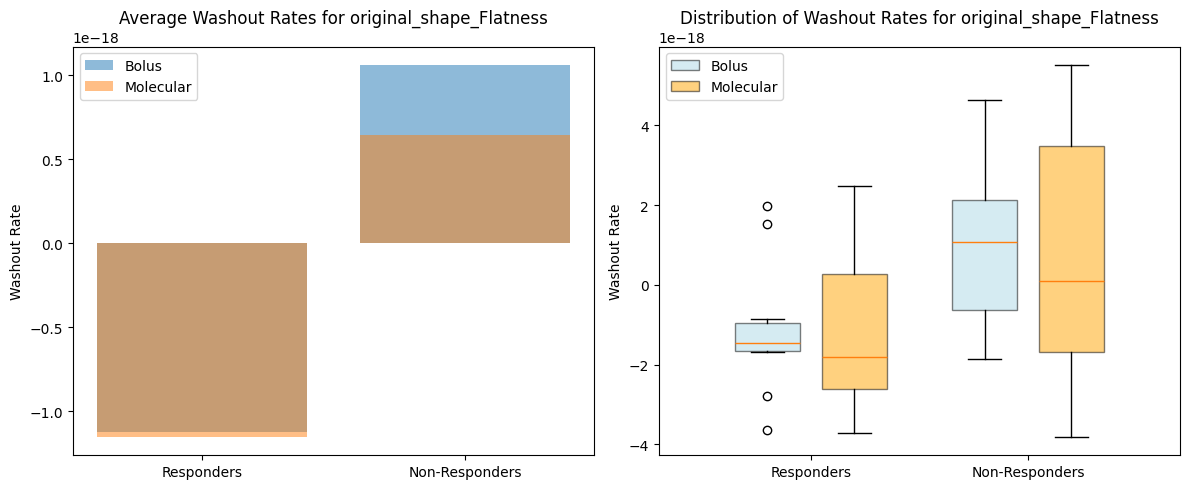

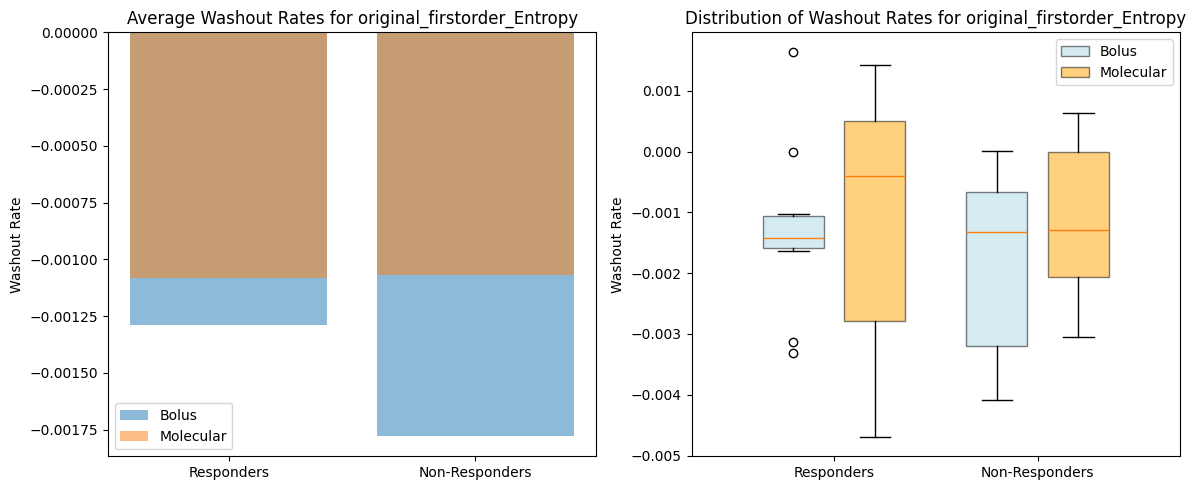

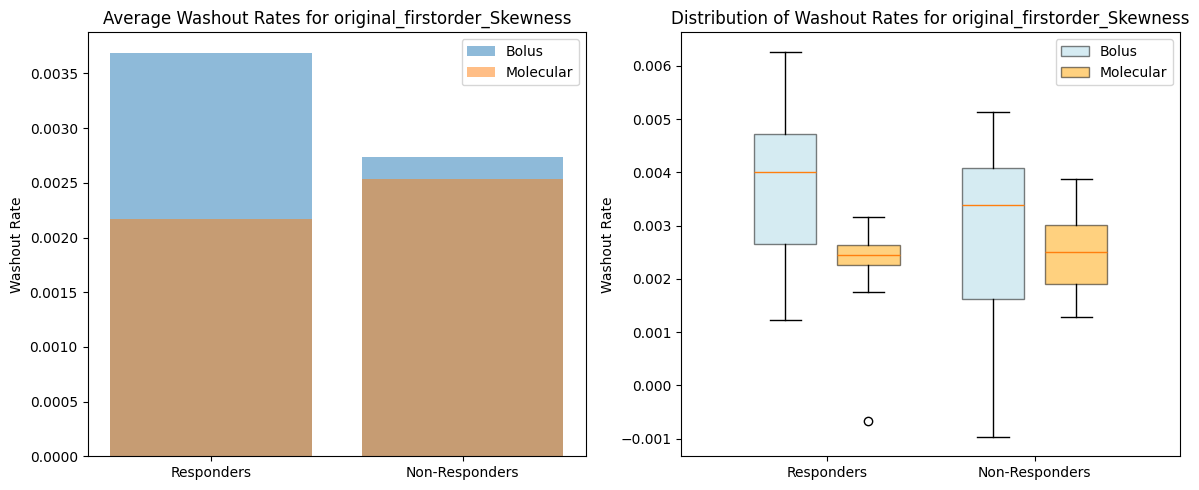

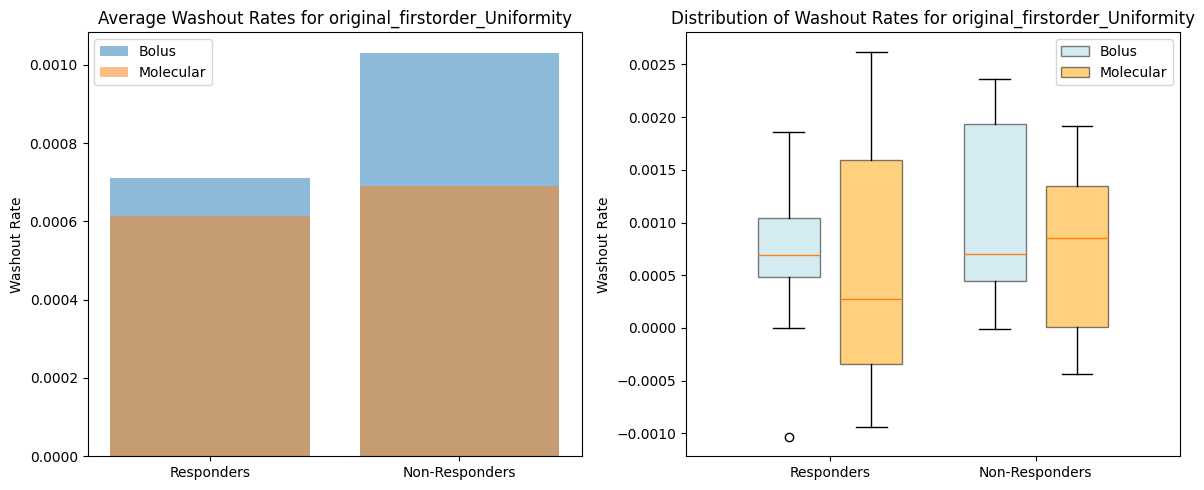

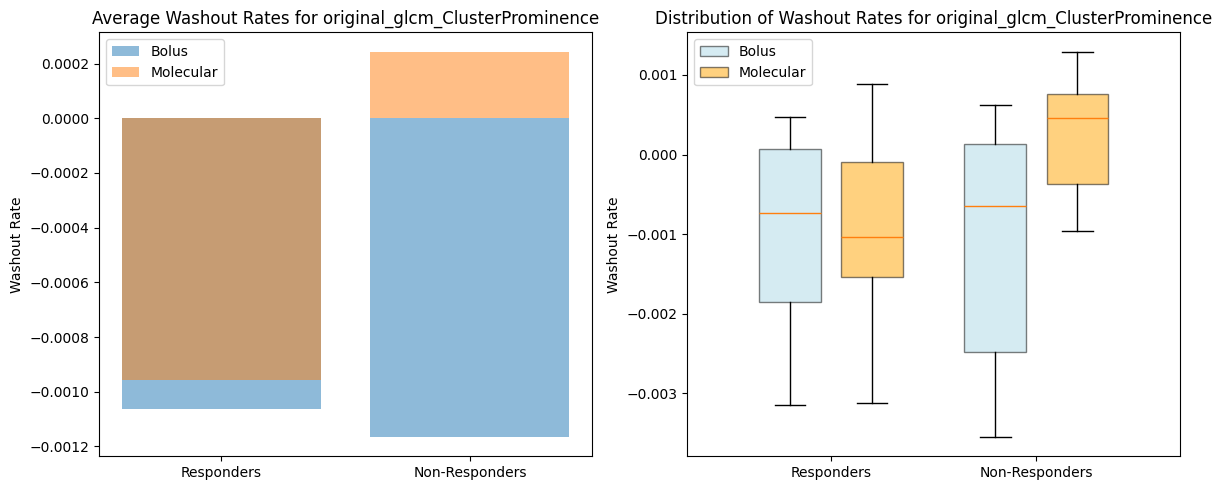

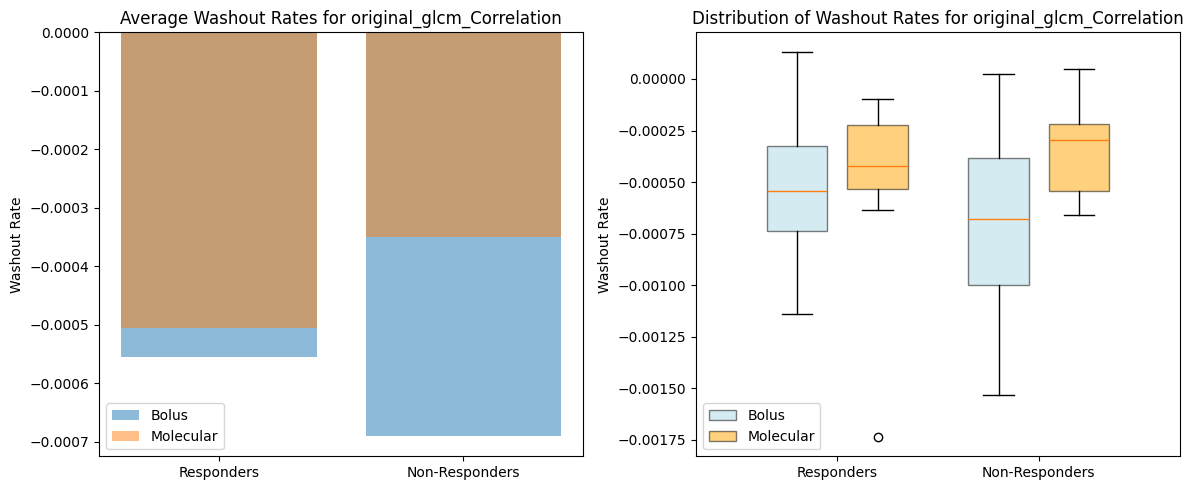

In [12]:
# Feature investigation for washout rate
features_of_interest = [11, 22, 23, 39, 50, 52, 55, 59]

for ix in features_of_interest:
    feature = features[ix]
    
    # Split data for this feature between responders and non-responders
    feature_data = stats_df[stats_df['feature'] == feature]
    responders = feature_data[feature_data['responder'] == True]
    non_responders = feature_data[feature_data['responder'] == False]
    
    # Calculate mean washout rates for each group
    resp_bolus_mean = responders['bolus_washout_rate'].mean()
    resp_molecular_mean = responders['molecular_washout_rate'].mean()
    nonresp_bolus_mean = non_responders['bolus_washout_rate'].mean()
    nonresp_molecular_mean = non_responders['molecular_washout_rate'].mean()
    
    # Create plots comparing the rates
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Bar plot of means
    x = ['Responders', 'Non-Responders']
    ax1.bar(x, [resp_bolus_mean, nonresp_bolus_mean], label='Bolus', alpha=0.5)
    ax1.bar(x, [resp_molecular_mean, nonresp_molecular_mean], label='Molecular', alpha=0.5)
    ax1.set_title(f'Average Washout Rates for {feature}')
    ax1.set_ylabel('Washout Rate')
    ax1.legend()
    
    # Box plots
    bp1 = ax2.boxplot([responders['bolus_washout_rate'], non_responders['bolus_washout_rate']], 
                      positions=[0.8, 1.8], widths=0.3, patch_artist=True)
    bp2 = ax2.boxplot([responders['molecular_washout_rate'], non_responders['molecular_washout_rate']], 
                      positions=[1.2, 2.2], widths=0.3, patch_artist=True)
    
    # Customize box plots
    for box in bp1['boxes']:
        box.set(facecolor='lightblue', alpha=0.5)
    for box in bp2['boxes']:
        box.set(facecolor='orange', alpha=0.5)
        
    ax2.set_xticks([1, 2])
    ax2.set_xticklabels(['Responders', 'Non-Responders'])
    ax2.set_title(f'Distribution of Washout Rates for {feature}')
    ax2.set_ylabel('Washout Rate')
    ax2.legend([bp1['boxes'][0], bp2['boxes'][0]], ['Bolus', 'Molecular'])
    
    plt.tight_layout()


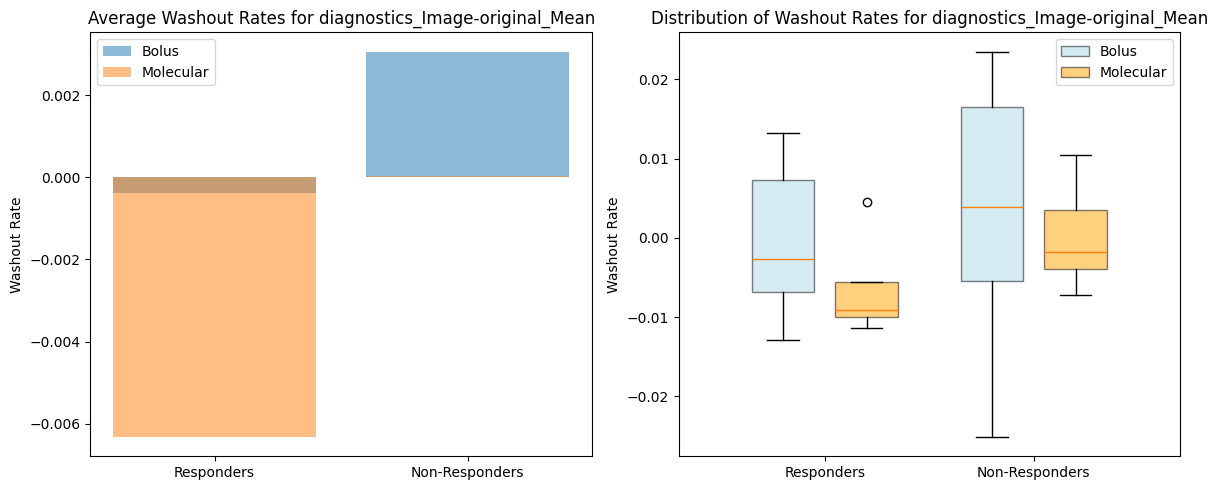

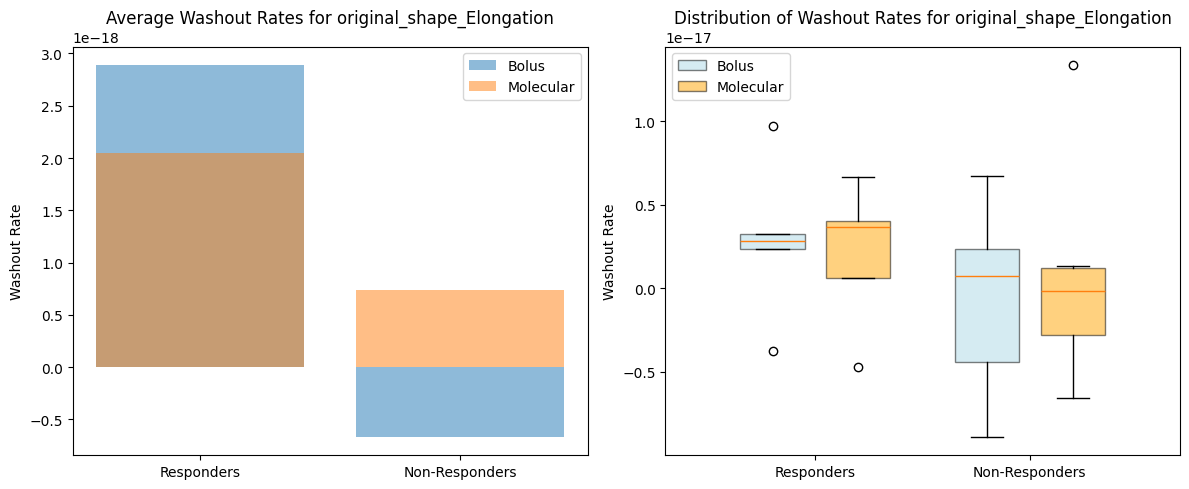

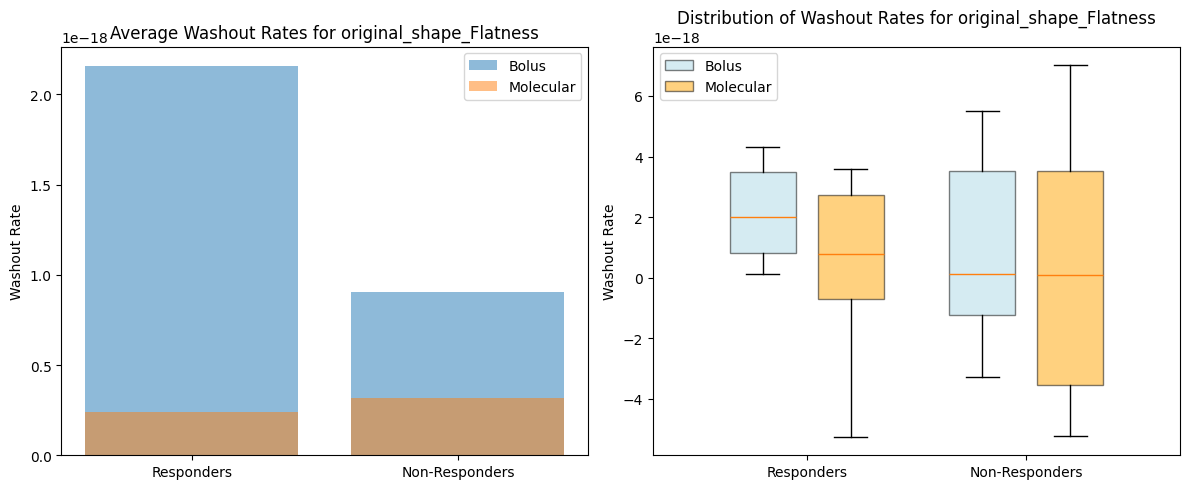

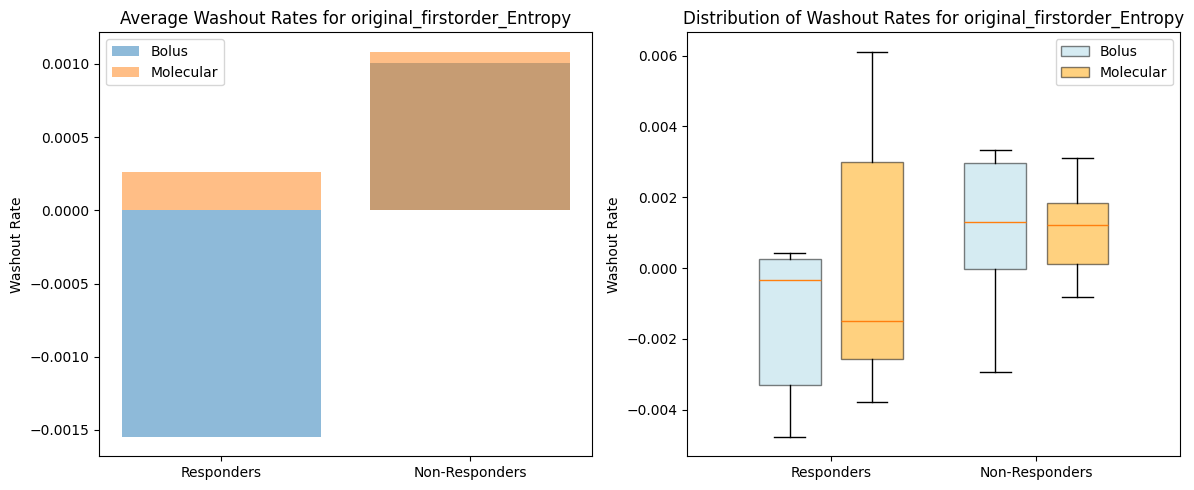

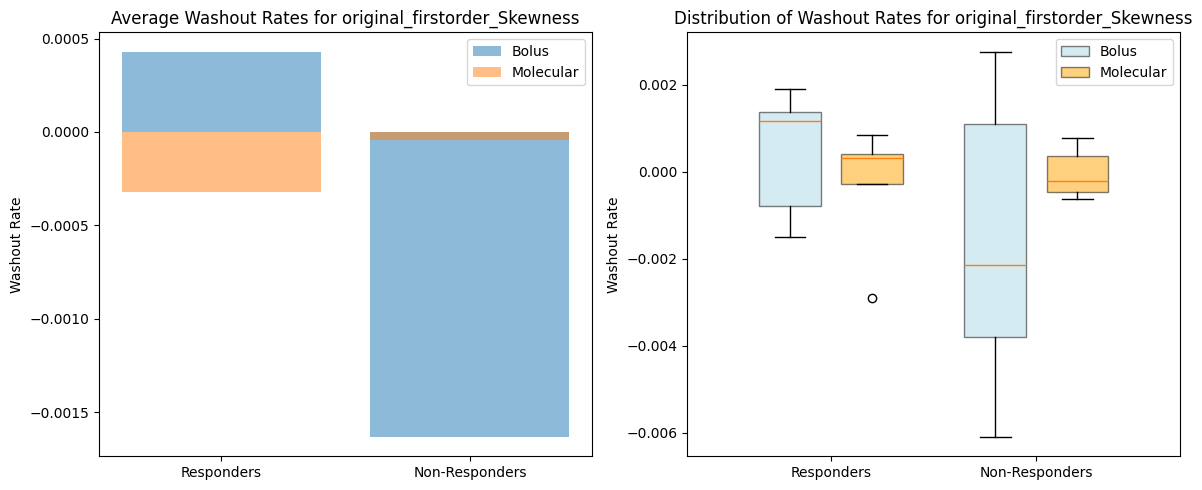

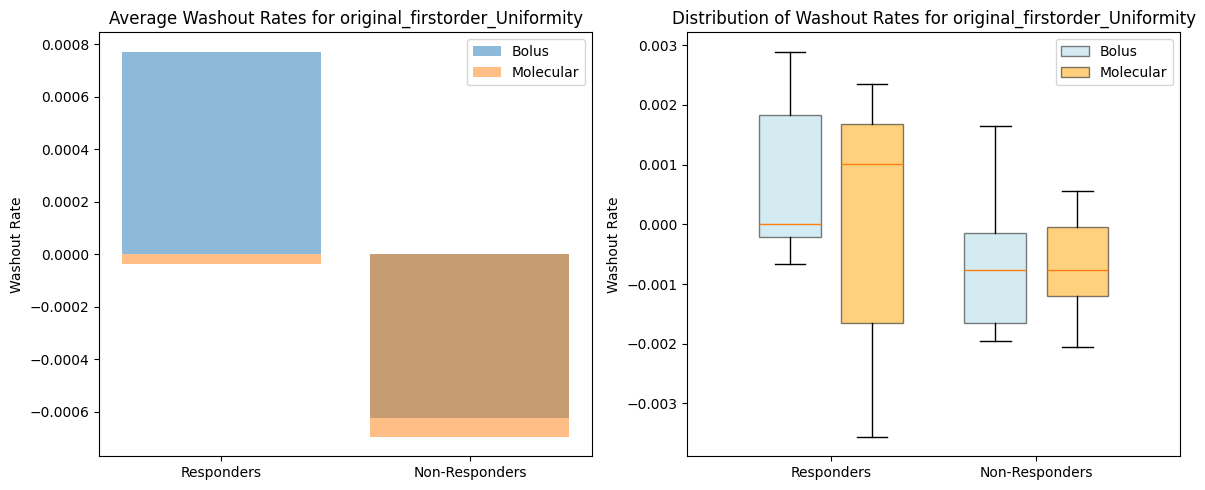

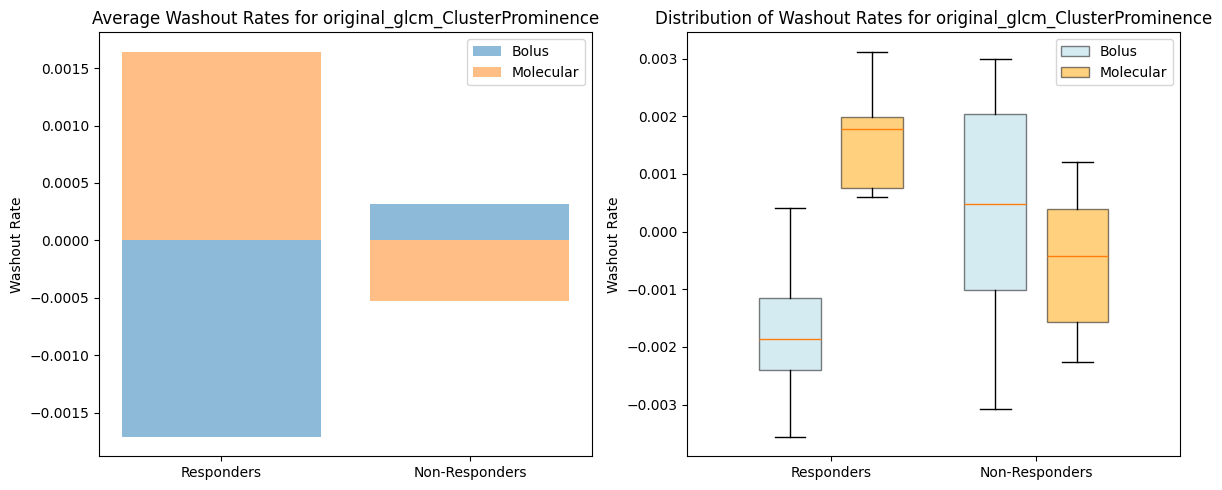

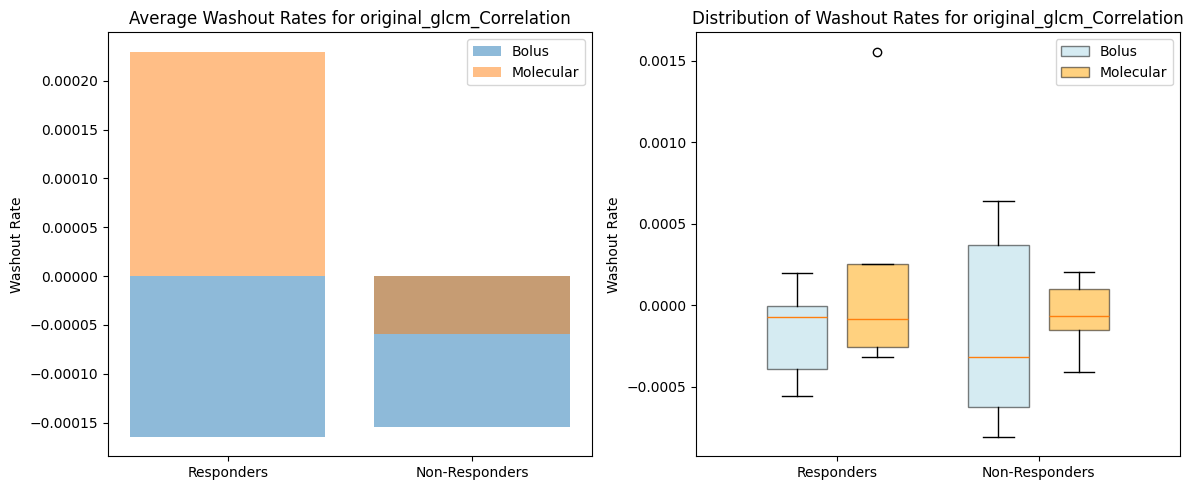

In [13]:
# Feature investigation for washout rate
features_of_interest = [11, 22, 23, 39, 50, 52, 55, 59]

for ix in features_of_interest:
    feature = features[ix]
    
    # Split data for this feature between responders and non-responders
    feature_data = diff_df[diff_df['feature'] == feature]
    responders = feature_data[feature_data['responder'] == True]
    non_responders = feature_data[feature_data['responder'] == False]
    
    # Calculate mean washout rates for each group
    resp_bolus_mean = responders['bolus_washout_rate_diff'].mean()
    resp_molecular_mean = responders['molecular_washout_rate_diff'].mean()
    nonresp_bolus_mean = non_responders['bolus_washout_rate_diff'].mean()
    nonresp_molecular_mean = non_responders['molecular_washout_rate_diff'].mean()
    
    # Create plots comparing the rates
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Bar plot of means
    x = ['Responders', 'Non-Responders']
    ax1.bar(x, [resp_bolus_mean, nonresp_bolus_mean], label='Bolus', alpha=0.5)
    ax1.bar(x, [resp_molecular_mean, nonresp_molecular_mean], label='Molecular', alpha=0.5)
    ax1.set_title(f'Average Washout Rates for {feature}')
    ax1.set_ylabel('Washout Rate')
    ax1.legend()
    
    # Box plots
    bp1 = ax2.boxplot([responders['bolus_washout_rate_diff'], non_responders['bolus_washout_rate_diff']], 
                      positions=[0.8, 1.8], widths=0.3, patch_artist=True)
    bp2 = ax2.boxplot([responders['molecular_washout_rate_diff'], non_responders['molecular_washout_rate_diff']], 
                      positions=[1.2, 2.2], widths=0.3, patch_artist=True)
    
    # Customize box plots
    for box in bp1['boxes']:
        box.set(facecolor='lightblue', alpha=0.5)
    for box in bp2['boxes']:
        box.set(facecolor='orange', alpha=0.5)
        
    ax2.set_xticks([1, 2])
    ax2.set_xticklabels(['Responders', 'Non-Responders'])
    ax2.set_title(f'Distribution of Washout Rates for {feature}')
    ax2.set_ylabel('Washout Rate')
    ax2.legend([bp1['boxes'][0], bp2['boxes'][0]], ['Bolus', 'Molecular'])
    
    plt.tight_layout()


Feature with least overlap: original_glszm_SmallAreaLowGrayLevelEmphasis
Overlap score: 0


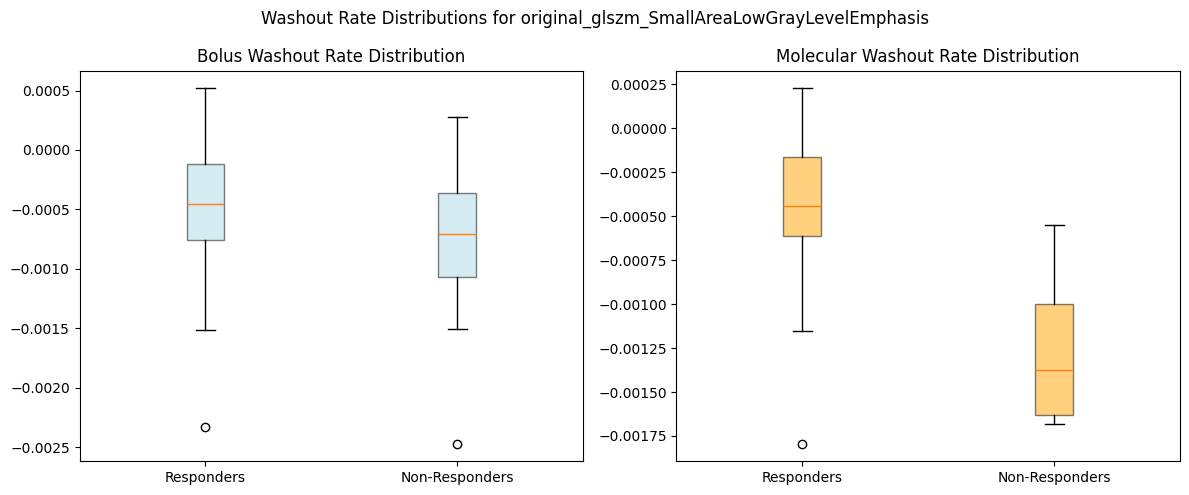

In [14]:
# Calculate range overlap for each feature
overlap_scores = []

for feature in stats_df['feature'].unique():
    if 'Minimum' in feature or 'shape' in feature:
        continue
    feature_data = stats_df[stats_df['feature'] == feature]
    responders = feature_data[feature_data['responder'] == True]
    non_responders = feature_data[feature_data['responder'] == False]
    # Calculate IQR for both washout rates
    high_percentile = 75; low_percentile = 25
    bolus_resp_q75, bolus_resp_q25 = np.percentile(responders['bolus_washout_rate'], [high_percentile, low_percentile])
    bolus_nonresp_q75, bolus_nonresp_q25 = np.percentile(non_responders['bolus_washout_rate'], [high_percentile, low_percentile])
    molecular_resp_q75, molecular_resp_q25 = np.percentile(responders['molecular_washout_rate'], [high_percentile, low_percentile])
    molecular_nonresp_q75, molecular_nonresp_q25 = np.percentile(non_responders['molecular_washout_rate'], [high_percentile, low_percentile])
    
    # Calculate IQR ranges
    bolus_resp_range = (bolus_resp_q25, bolus_resp_q75)
    bolus_nonresp_range = (bolus_nonresp_q25, bolus_nonresp_q75)
    
    molecular_resp_range = (molecular_resp_q25, molecular_resp_q75)
    molecular_nonresp_range = (molecular_nonresp_q25, molecular_nonresp_q75)
    
    # Calculate overlap for bolus
    bolus_overlap = max(0, min(bolus_resp_range[1], bolus_nonresp_range[1]) - 
                       max(bolus_resp_range[0], bolus_nonresp_range[0]))
    
    # Calculate overlap for molecular
    molecular_overlap = max(0, min(molecular_resp_range[1], molecular_nonresp_range[1]) - 
                          max(molecular_resp_range[0], molecular_nonresp_range[0]))
    
    # Total overlap score
    total_overlap = bolus_overlap + molecular_overlap
    overlap_scores.append((feature, molecular_overlap))

# Find feature with minimum overlap
best_feature = min(overlap_scores, key=lambda x: x[1])
print(f"Feature with least overlap: {best_feature[0]}")
print(f"Overlap score: {best_feature[1]}")

# Plot the distributions for the best feature
feature_data = stats_df[stats_df['feature'] == best_feature[0]]
responders = feature_data[feature_data['responder'] == True]
non_responders = feature_data[feature_data['responder'] == False]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Box plots for bolus
bp1 = ax1.boxplot([responders['bolus_washout_rate'], non_responders['bolus_washout_rate']], 
                  positions=[1, 2], patch_artist=True)
for box in bp1['boxes']:
    box.set(facecolor='lightblue', alpha=0.5)
ax1.set_title('Bolus Washout Rate Distribution')
ax1.set_xticks([1, 2])
ax1.set_xticklabels(['Responders', 'Non-Responders'])

# Box plots for molecular
bp2 = ax2.boxplot([responders['molecular_washout_rate'], non_responders['molecular_washout_rate']], 
                  positions=[1, 2], patch_artist=True)
for box in bp2['boxes']:
    box.set(facecolor='orange', alpha=0.5)
ax2.set_title('Molecular Washout Rate Distribution')
ax2.set_xticks([1, 2])
ax2.set_xticklabels(['Responders', 'Non-Responders'])

plt.suptitle(f'Washout Rate Distributions for {best_feature[0]}')
plt.tight_layout()


Feature with least overlap: original_glrlm_RunEntropy
Overlap score: 2


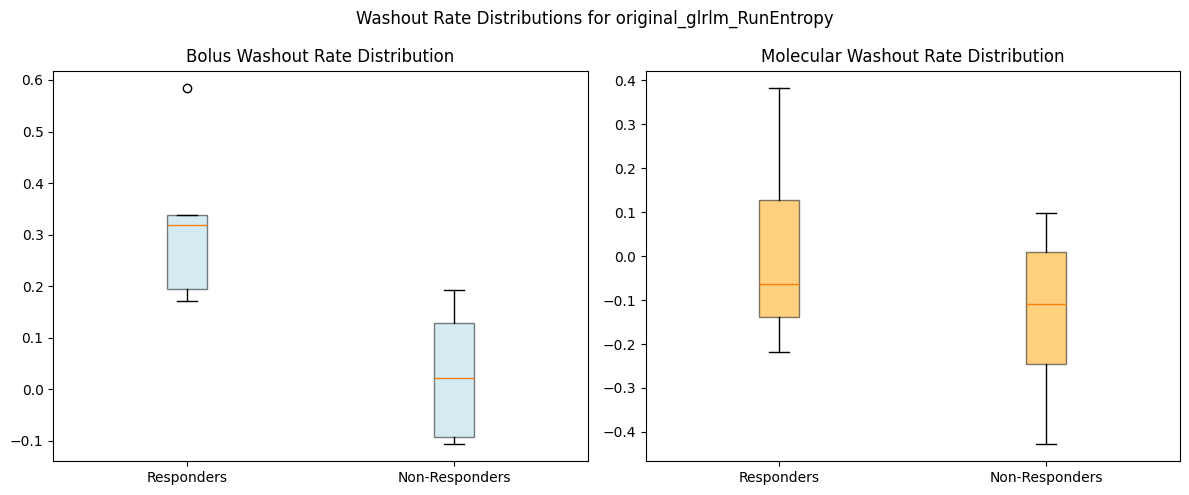

In [15]:
# Calculate range overlap for each feature
overlap_scores = []

for feature in diff_df['feature'].unique():
    if 'Minimum' in feature:
        continue
    feature_data = diff_df[diff_df['feature'] == feature]
    responders = feature_data[feature_data['responder'] == True]
    non_responders = feature_data[feature_data['responder'] == False]
    
    # Calculate number of overlapping points
    bolus_resp_points = responders['mean_bolus_diff'].values
    bolus_nonresp_points = non_responders['mean_bolus_diff'].values
    
    molecular_resp_points = responders['mean_molecular_diff'].values 
    molecular_nonresp_points = non_responders['mean_molecular_diff'].values
    
    # Find min/max ranges
    bolus_resp_min, bolus_resp_max = np.min(bolus_resp_points), np.max(bolus_resp_points)
    bolus_nonresp_min, bolus_nonresp_max = np.min(bolus_nonresp_points), np.max(bolus_nonresp_points)
    
    molecular_resp_min, molecular_resp_max = np.min(molecular_resp_points), np.max(molecular_resp_points)
    molecular_nonresp_min, molecular_nonresp_max = np.min(molecular_nonresp_points), np.max(molecular_nonresp_points)
    
    # Count points in overlapping range for bolus
    bolus_overlap_range = (max(bolus_resp_min, bolus_nonresp_min), 
                          min(bolus_resp_max, bolus_nonresp_max))
    bolus_overlap_count = (
        np.sum((bolus_resp_points >= bolus_overlap_range[0]) & 
               (bolus_resp_points <= bolus_overlap_range[1])) +
        np.sum((bolus_nonresp_points >= bolus_overlap_range[0]) & 
               (bolus_nonresp_points <= bolus_overlap_range[1]))
    )
    
    # Count points in overlapping range for molecular
    molecular_overlap_range = (max(molecular_resp_min, molecular_nonresp_min),
                             min(molecular_resp_max, molecular_nonresp_max))
    molecular_overlap_count = (
        np.sum((molecular_resp_points >= molecular_overlap_range[0]) & 
               (molecular_resp_points <= molecular_overlap_range[1])) +
        np.sum((molecular_nonresp_points >= molecular_overlap_range[0]) & 
               (molecular_nonresp_points <= molecular_overlap_range[1]))
    )
    
    overlap_scores.append((feature, bolus_overlap_count))

# Find feature with minimum overlap
best_feature = min(overlap_scores, key=lambda x: x[1])
print(f"Feature with least overlap: {best_feature[0]}")
print(f"Overlap score: {best_feature[1]}")

# Plot the distributions for the best feature
feature_data = diff_df[diff_df['feature'] == best_feature[0]]
responders = feature_data[feature_data['responder'] == True]
non_responders = feature_data[feature_data['responder'] == False]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Box plots for bolus
bp1 = ax1.boxplot([responders['mean_bolus_diff'], non_responders['mean_bolus_diff']], 
                  positions=[1, 2], patch_artist=True)
for box in bp1['boxes']:
    box.set(facecolor='lightblue', alpha=0.5)
ax1.set_title('Bolus Washout Rate Distribution')
ax1.set_xticks([1, 2])
ax1.set_xticklabels(['Responders', 'Non-Responders'])

# Box plots for molecular
bp2 = ax2.boxplot([responders['mean_molecular_diff'], non_responders['mean_molecular_diff']], 
                  positions=[1, 2], patch_artist=True)
for box in bp2['boxes']:
    box.set(facecolor='orange', alpha=0.5)
ax2.set_title('Molecular Washout Rate Distribution')
ax2.set_xticks([1, 2])
ax2.set_xticklabels(['Responders', 'Non-Responders'])

plt.suptitle(f'Washout Rate Distributions for {best_feature[0]}')
plt.tight_layout()


In [17]:
responders.head()

,mouse,feature,group,responder,bolus_washout_rate_diff,molecular_washout_rate_diff,min_bolus_diff,max_bolus_diff,mean_bolus_diff,median_bolus_diff,min_molecular_diff,max_molecular_diff,mean_molecular_diff,median_molecular_diff,std_bolus_diff,std_molecular_diff
69,m908,original_glrlm_RunEntropy,LSAV,True,0.005127,-0.006584,0.631001,0.123588,0.583711,0.694483,0.544936,0.308968,0.128169,0.176409,-0.184719,-0.031870
293,m907,original_glrlm_RunEntropy,LSAV,True,-0.002093,-0.003417,-0.268578,0.393270,0.171599,0.124326,0.000009,-0.113115,-0.137619,-0.184474,0.111224,-0.043191
405,m904,original_glrlm_RunEntropy,LSAV,True,0.002228,0.004072,0.222923,0.537738,0.318463,0.303825,0.357349,0.821307,0.381980,0.331696,0.076076,0.150540
629,m935,original_glrlm_RunEntropy,LSAV,True,0.004214,0.000316,0.155783,0.073894,0.193713,0.169630,-0.234892,0.043908,-0.218670,-0.299769,0.022470,0.122218
853,m933,original_glrlm_RunEntropy,LSAV,True,0.000519,0.001185,0.270231,0.039715,0.338403,0.393213,-0.086498,0.083787,-0.063183,-0.091759,0.016482,0.059512


Feature: original_glcm_ClusterProminence, Column: max_molecular_diff, Overlap Count: 0
Feature: original_gldm_LargeDependenceLowGrayLevelEmphasis, Column: std_molecular_diff, Overlap Count: 0
Feature with least overlap: original_glcm_ClusterProminence
Feature with least overlap column: max_molecular_diff
Overlap score: 0


/var/folders/5z/myjw1nc12n3g808z31wz0kt80000gn/T/ipykernel_26899/521421060.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  responders[col] = responders[col].values
/var/folders/5z/myjw1nc12n3g808z31wz0kt80000gn/T/ipykernel_26899/521421060.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_responders[col] = non_responders[col].values


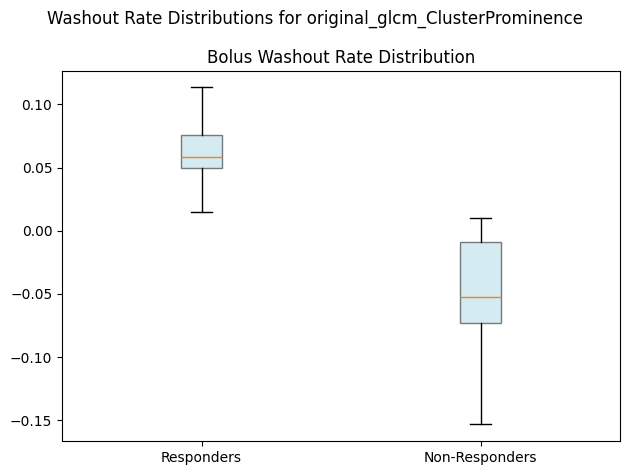

In [ ]:
# Calculate range overlap for each feature
overlap_scores = []

cols = ['bolus_washout_rate_diff', 'molecular_washout_rate_diff', 'mean_bolus_diff', 'median_bolus_diff', 'mean_molecular_diff', 'median_molecular_diff', 'std_bolus_diff', 'std_molecular_diff']
cols = ['bolus_washout_rate_diff',	'molecular_washout_rate_diff',	'min_bolus_diff',	'max_bolus_diff',	'mean_bolus_diff',	'median_bolus_diff',	'min_molecular_diff',	'max_molecular_diff',	'mean_molecular_diff',	'median_molecular_diff',	'std_bolus_diff',	'std_molecular_diff']

for feature in diff_df['feature'].unique():
    # if 'Minimum' in feature or 'shape' in feature:
        # continue
    feature_data = diff_df[diff_df['feature'] == feature]
    responders = feature_data[feature_data['responder'] == True]
    non_responders = feature_data[feature_data['responder'] == False]
    
    # Calculate number of overlapping points
    min_col = ""
    min_overlap = 1000000
    for col in cols:
        responders[col] = responders[col].values
        non_responders[col] = non_responders[col].values
        
        resp_min, resp_max = np.min(responders[col]), np.max(responders[col])
        nonresp_min, nonresp_max = np.min(non_responders[col]), np.max(non_responders[col])
        overlap_range = (max(resp_min, nonresp_min), min(resp_max, nonresp_max))
        
        if overlap_range[0] > overlap_range[1]:
            overlap_count = 0
        else:
            overlap_count = (
                np.sum((responders[col].values >= overlap_range[0]) &
                       (responders[col].values <= overlap_range[1])) +
                np.sum((non_responders[col].values >= overlap_range[0]) &
                       (non_responders[col].values <= overlap_range[1]))
            ) + 1
        if overlap_count < min_overlap:
            min_overlap = overlap_count
            min_col = col
            min_overlap_range = overlap_range
        if overlap_count == 0:
            print(f"Feature: {feature}, Column: {col}, Overlap Count: {overlap_count}")
            
        if feature == "original_shape_Maximum3DDiameter" and col == "std_moecular_diff":
            print(f"Feature: {feature}, Column: {col}, Overlap Count: {overlap_count}")
            print(f"Overlap Range: {overlap_range}")
            print(f"Responders: {responders[col].values}")
            print(f"Non-responders: {non_responders[col].values}")
    overlap_scores.append((feature, min_col, min_overlap, min_overlap_range))

# Find feature with minimum overlap
best_feature = min(overlap_scores, key=lambda x: x[2])
print(f"Feature with least overlap: {best_feature[0]}")
print(f"Feature with least overlap column: {best_feature[1]}")
print(f"Overlap score: {best_feature[2]}")

# Plot the distributions for the best feature
feature_data = diff_df[diff_df['feature'] == best_feature[0]]
responders = feature_data[feature_data['responder'] == True]
non_responders = feature_data[feature_data['responder'] == False]

fig, ax = plt.subplots()

# Box plots for bolus
bp1 = ax.boxplot([responders[best_feature[1]], non_responders[best_feature[1]]], 
                  positions=[1, 2], patch_artist=True)
for box in bp1['boxes']:
    box.set(facecolor='lightblue', alpha=0.5)
ax.set_title('Bolus Washout Rate Distribution')
ax.set_xticks([1, 2])
ax.set_xticklabels(['Responders', 'Non-Responders'])

plt.suptitle(f'Washout Rate Distributions for {best_feature[0]}')
plt.tight_layout()


In [105]:
best_feature[-1]

(np.float64(0.014406104267925102), np.float64(0.010102562622565148))

Optimal threshold: 0.131
Accuracy: 0.909


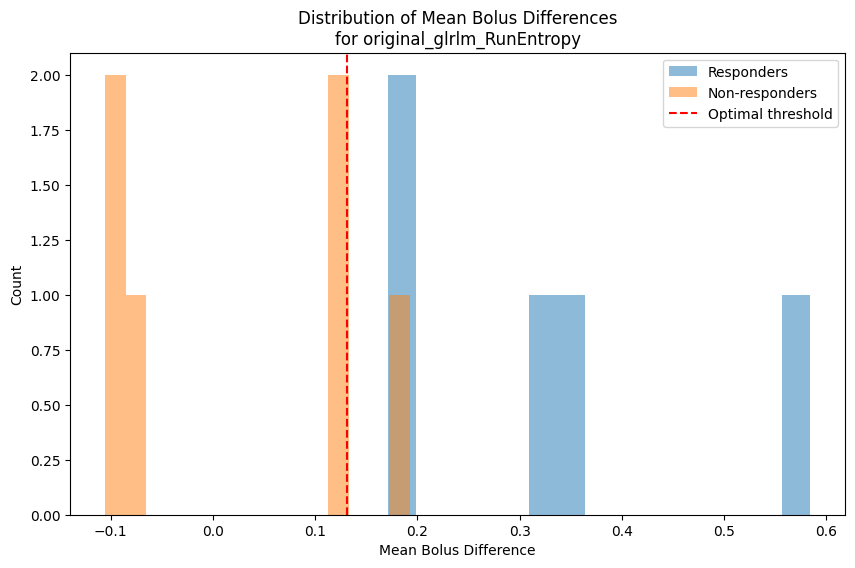

In [20]:
# Extract data for the specified feature
feature_data = diff_df[diff_df['feature'] == 'original_glrlm_RunEntropy']

# Get bolus washout rate differences for responders and non-responders
responder_rates = feature_data[feature_data['responder']]['mean_bolus_diff']
nonresponder_rates = feature_data[feature_data['responder'] == False]['mean_bolus_diff']

# Try different thresholds and calculate accuracy
thresholds = np.linspace(min(feature_data['mean_bolus_diff']), 
                        max(feature_data['mean_bolus_diff']), 
                        100)
best_accuracy = 0
best_threshold = None

for threshold in thresholds:
    # Predict responders based on threshold
    predicted = feature_data['mean_bolus_diff'] > threshold
    actual = feature_data['responder']
    
    # Calculate accuracy
    accuracy = np.mean(predicted == actual)
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_threshold = threshold

print(f"Optimal threshold: {best_threshold:.3f}")
print(f"Accuracy: {best_accuracy:.3f}")

# Plot the distributions with the threshold line
plt.figure(figsize=(10, 6))
plt.hist(responder_rates, alpha=0.5, label='Responders', bins=15)
plt.hist(nonresponder_rates, alpha=0.5, label='Non-responders', bins=15)
plt.axvline(x=best_threshold, color='r', linestyle='--', label='Optimal threshold')
plt.xlabel('Mean Bolus Difference')
plt.ylabel('Count')
plt.title('Distribution of Mean Bolus Differences\nfor original_glrlm_RunEntropy')
plt.legend()
plt.show()


Optimal threshold: -0.003
Accuracy: 0.909


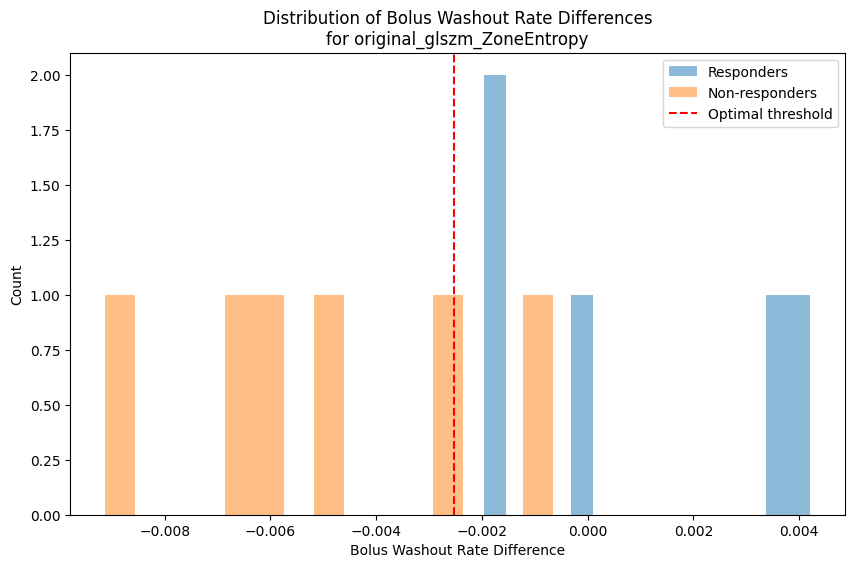

In [21]:
# Extract data for the specified feature
feature_data = diff_df[diff_df['feature'] == 'original_glszm_ZoneEntropy']

# Get bolus washout rate differences for responders and non-responders
responder_rates = feature_data[feature_data['responder']]['bolus_washout_rate_diff']
nonresponder_rates = feature_data[feature_data['responder'] == False]['bolus_washout_rate_diff']

# Try different thresholds and calculate accuracy
thresholds = np.linspace(min(feature_data['bolus_washout_rate_diff']), 
                        max(feature_data['bolus_washout_rate_diff']), 
                        100)
best_accuracy = 0
best_threshold = None

for threshold in thresholds:
    # Predict responders based on threshold
    predicted = feature_data['bolus_washout_rate_diff'] > threshold
    actual = feature_data['responder']
    
    # Calculate accuracy
    accuracy = np.mean(predicted == actual)
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_threshold = threshold

print(f"Optimal threshold: {best_threshold:.3f}")
print(f"Accuracy: {best_accuracy:.3f}")

# Plot the distributions with the threshold line
plt.figure(figsize=(10, 6))
plt.hist(responder_rates, alpha=0.5, label='Responders', bins=15)
plt.hist(nonresponder_rates, alpha=0.5, label='Non-responders', bins=15)
plt.axvline(x=best_threshold, color='r', linestyle='--', label='Optimal threshold')
plt.xlabel('Bolus Washout Rate Difference')
plt.ylabel('Count')
plt.title('Distribution of Bolus Washout Rate Differences\nfor original_glszm_ZoneEntropy')
plt.legend()
plt.show()


Optimal threshold: 0.001
Accuracy: 0.909


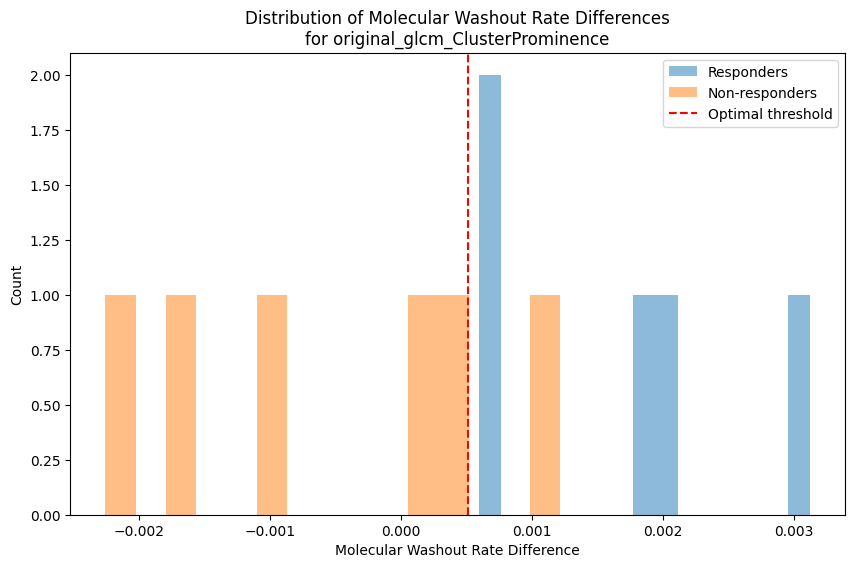

In [113]:
# Extract data for the specified feature
feature_data = diff_df[diff_df['feature'] == 'original_glcm_ClusterProminence']

# Get molecular washout rate differences for responders and non-responders
responder_rates = feature_data[feature_data['responder']]['molecular_washout_rate_diff']
nonresponder_rates = feature_data[feature_data['responder'] == False]['molecular_washout_rate_diff']

# Try different thresholds and calculate accuracy
thresholds = np.linspace(min(feature_data['molecular_washout_rate_diff']), 
                        max(feature_data['molecular_washout_rate_diff']), 
                        100)
best_accuracy = 0
best_threshold = None

for threshold in thresholds:
    # Predict responders based on threshold
    predicted = feature_data['molecular_washout_rate_diff'] > threshold
    actual = feature_data['responder']
    
    # Calculate accuracy
    accuracy = np.mean(predicted == actual)
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_threshold = threshold

print(f"Optimal threshold: {best_threshold:.3f}")
print(f"Accuracy: {best_accuracy:.3f}")

# Plot the distributions with the threshold line
plt.figure(figsize=(10, 6))
plt.hist(responder_rates, alpha=0.5, label='Responders', bins=15)
plt.hist(nonresponder_rates, alpha=0.5, label='Non-responders', bins=15)
plt.axvline(x=best_threshold, color='r', linestyle='--', label='Optimal threshold')
plt.xlabel('Molecular Washout Rate Difference')
plt.ylabel('Count')
plt.title('Distribution of Molecular Washout Rate Differences\nfor original_glcm_ClusterProminence')
plt.legend()
plt.show()


In [ ]:
# Extract data for the specified feature
feature_data = diff_df[diff_df['feature'] == 'original_glcm_ClusterProminence']

# Get molecular washout rate differences for responders and non-responders
responder_rates = feature_data[feature_data['responder']]['molecular_washout_rate_diff']
nonresponder_rates = feature_data[feature_data['responder'] == False]['molecular_washout_rate_diff']

# Try different thresholds and calculate accuracy
thresholds = np.linspace(min(feature_data['molecular_washout_rate_diff']), 
                        max(feature_data['molecular_washout_rate_diff']), 
                        100)
best_accuracy = 0
best_threshold = None

for threshold in thresholds:
    # Predict responders based on threshold
    predicted = feature_data['molecular_washout_rate_diff'] > threshold
    actual = feature_data['responder']
    
    # Calculate accuracy
    accuracy = np.mean(predicted == actual)
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_threshold = threshold

print(f"Optimal threshold: {best_threshold:.3f}")
print(f"Accuracy: {best_accuracy:.3f}")

# Plot the distributions with the threshold line
plt.figure(figsize=(10, 6))
plt.hist(responder_rates, alpha=0.5, label='Responders', bins=15)
plt.hist(nonresponder_rates, alpha=0.5, label='Non-responders', bins=15)
plt.axvline(x=best_threshold, color='r', linestyle='--', label='Optimal threshold')
plt.xlabel('Molecular Washout Rate Difference')
plt.ylabel('Count')
plt.title('Distribution of Molecular Washout Rate Differences\nfor original_glcm_ClusterProminence')
plt.legend()
plt.show()


Optimal threshold: 3.749
Accuracy: 1.000


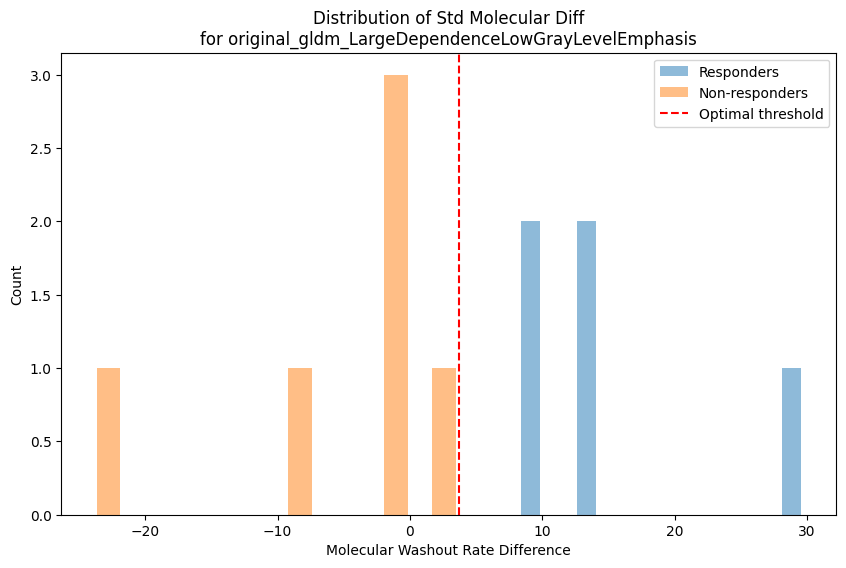

In [116]:
# Extract data for the specified feature
feature_data = diff_df[diff_df['feature'] == 'original_gldm_LargeDependenceLowGrayLevelEmphasis']

# Get molecular washout rate differences for responders and non-responders
responder_rates = feature_data[feature_data['responder']]['std_molecular_diff']
nonresponder_rates = feature_data[feature_data['responder'] == False]['std_molecular_diff']

# Try different thresholds and calculate accuracy
thresholds = np.linspace(min(feature_data['std_molecular_diff']), 
                        max(feature_data['std_molecular_diff']), 
                        100)
best_accuracy = 0
best_threshold = None

for threshold in thresholds:
    # Predict responders based on threshold
    predicted = feature_data['std_molecular_diff'] > threshold
    actual = feature_data['responder']
    
    # Calculate accuracy
    accuracy = np.mean(predicted == actual)
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_threshold = threshold

print(f"Optimal threshold: {best_threshold:.3f}")
print(f"Accuracy: {best_accuracy:.3f}")

# Plot the distributions with the threshold line
plt.figure(figsize=(10, 6))
plt.hist(responder_rates, alpha=0.5, label='Responders', bins=15)
plt.hist(nonresponder_rates, alpha=0.5, label='Non-responders', bins=15)
plt.axvline(x=best_threshold, color='r', linestyle='--', label='Optimal threshold')
plt.xlabel('Molecular Washout Rate Difference')
plt.ylabel('Count')
plt.title('Distribution of Std Molecular Diff\nfor original_gldm_LargeDependenceLowGrayLevelEmphasis')
plt.legend()
plt.show()


# How many features perfectly split data? How many are perfect but one? P-value / how big of room for variability do we have? SEEMS OFF FOR NONZERO CASES

# PCA-SVM, PCA-LDA, PCA-MLP

In [23]:
# Pivot the diff_df to create a new dataframe where each row is a mouse
# and columns are the features with their respective metrics
mouse_df = diff_df.pivot(index=['mouse', 'group', 'responder'], 
                        columns='feature',
                        values=['bolus_washout_rate_diff', 'molecular_washout_rate_diff',
                               'min_bolus_diff', 'max_bolus_diff', 'mean_bolus_diff',
                               'median_bolus_diff', 'min_molecular_diff', 'max_molecular_diff',
                               'mean_molecular_diff', 'median_molecular_diff',
                               'std_bolus_diff', 'std_molecular_diff'])

# Flatten the multi-level column names
mouse_df.columns = [f"{col[0]}_{col[1]}" for col in mouse_df.columns]

# Reset index to make mouse, group and responder regular columns
mouse_df = mouse_df.reset_index()

Cross-validation scores: [1.  0.5 0.5 1.  1. ]
Average CV score: 0.800 (+/- 0.490)

Classification Report:
              precision    recall  f1-score   support

       False       0.75      1.00      0.86         6
        True       1.00      0.60      0.75         5

    accuracy                           0.82        11
   macro avg       0.88      0.80      0.80        11
weighted avg       0.86      0.82      0.81        11



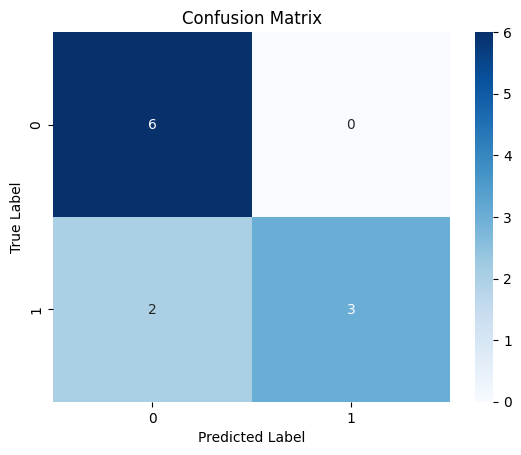

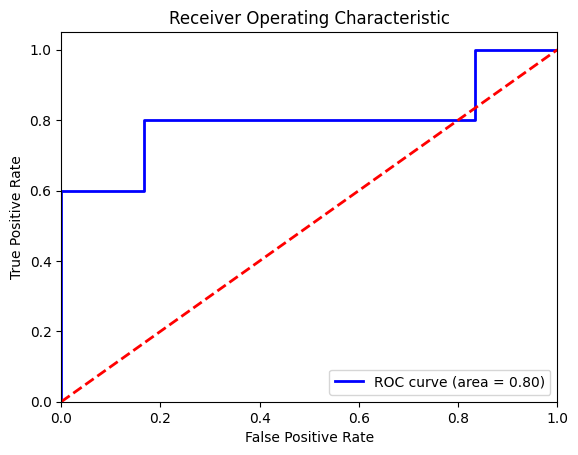

In [58]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Prepare X (features) and y (target) for modeling
X = mouse_df.drop(['mouse', 'group', 'responder'], axis=1)
y = mouse_df['responder']

# Determine number of components for PCA
# n_components = min(len(X.columns), len(X) - 1)

# Create a pipeline with PCA and SVM
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    # ('pca', PCA(n_components=1)),
    # ('svm', SVC(kernel='rbf', probability=True))
    ('pca', PCA(n_components=6)),
    ('lda', LinearDiscriminantAnalysis()),
])

# Perform cross-validation
# cv = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(pipeline, X, y, cv=cv)

y_trues = []; y_preds = []; y_probs = []
for i, (train_ix, test_ix) in enumerate(cv.split(X)):
    X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
    y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]
    
    # Fit the pipeline
    pipeline.fit(X_train, y_train)
    
    # Get predictions
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1]
    
    # Store true and predicted values
    y_trues.extend(y_test)
    y_preds.extend(y_pred)
    y_probs.extend(y_prob)

print("Cross-validation scores:", cv_scores)
print("Average CV score: {:.3f} (+/- {:.3f})".format(cv_scores.mean(), cv_scores.std() * 2))


# Print classification report
print("\nClassification Report:")
print(classification_report(y_trues, y_preds))

# Plot confusion matrix
plt.figure()
cm = confusion_matrix(y_trues, y_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Plot ROC curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_trues, y_probs)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

/var/folders/5z/myjw1nc12n3g808z31wz0kt80000gn/T/ipykernel_53677/3053174230.py:84: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  torch_loo_scores.extend(np.array(pred_class == y_test).flatten())
/var/folders/5z/myjw1nc12n3g808z31wz0kt80000gn/T/ipykernel_53677/3053174230.py:85: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  torch_y_pred_all.extend(np.array(pred_class).flatten())
/var/folders/5z/myjw1nc12n3g808z31wz0kt80000gn/T/ipykernel_53677/3053174230.py:86: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  torch_y_true_all.extend(np.array(y_test).flatten())
/var/folders/5z/myjw1nc12n3g808z31wz0kt80000gn/T/ipykernel_53677


PyTorch Leave-One-Out Cross Validation Accuracy: 0.818


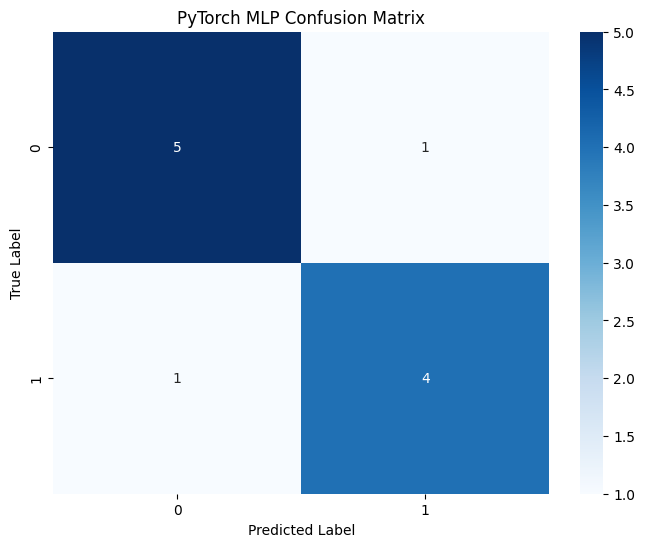


PyTorch Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      0.83      0.83         6
         1.0       0.80      0.80      0.80         5

    accuracy                           0.82        11
   macro avg       0.82      0.82      0.82        11
weighted avg       0.82      0.82      0.82        11



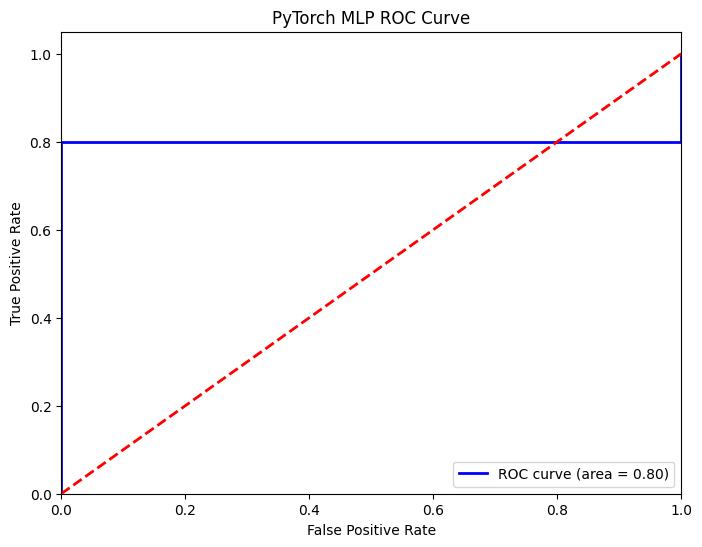

In [70]:
import torch

# Set random seed for reproducibility
torch.manual_seed(71)
torch.cuda.manual_seed(71)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

X = mouse_df.drop(['mouse', 'group', 'responder'], axis=1)
y = mouse_df['responder']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Select number of components that explain 95% of variance
n_components = 3

# Reduce dimensions to selected components
pca_final = PCA(n_components=n_components)
X_pca_final = pca_final.fit_transform(X_scaled)

# Create a simple MLP classifier using PyTorch
class MLP(torch.nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.layer1 = torch.nn.Linear(input_size, 20)
        self.layer2 = torch.nn.Linear(20, 1)
        self.relu = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.sigmoid(self.layer2(x))
        return x

# Convert data to PyTorch tensors
X_tensor = torch.FloatTensor(X_pca_final)
y_tensor = torch.FloatTensor(y.values.reshape(-1, 1))

# Perform Leave-One-Out Cross Validation with PyTorch
loo = KFold(n_splits=5, shuffle=True, random_state=42)
torch_loo_scores = []
torch_y_pred_all = []
torch_y_true_all = []
torch_y_probs_all = []

for train_idx, test_idx in loo.split(X_pca_final):
    # Split data
    X_train = X_tensor[train_idx]
    X_test = X_tensor[test_idx]
    y_train = y_tensor[train_idx]
    y_test = y_tensor[test_idx]
    
    # Initialize model and optimizer
    model = MLP(input_size=X_pca_final.shape[1])
    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    
    # Train the model
    model.train()
    for epoch in range(1000):
        optimizer.zero_grad()
        outputs = model(X_train)
        
        # Add L2 regularization
        l2_lambda = 0.01
        l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
        loss = criterion(outputs, y_train) + l2_lambda * l2_norm
        
        loss.backward()
        optimizer.step()
    
    # Make prediction
    model.eval()
    with torch.no_grad():
        pred = model(X_test)
        pred_class = (pred >= 0.5).float()
        
    torch_loo_scores.extend(np.array(pred_class == y_test).flatten())
    torch_y_pred_all.extend(np.array(pred_class).flatten())
    torch_y_true_all.extend(np.array(y_test).flatten())
    torch_y_probs_all.extend(np.array(pred).flatten())
# Calculate and print results
torch_loo_accuracy = np.mean(torch_loo_scores)
print(f"\nPyTorch Leave-One-Out Cross Validation Accuracy: {torch_loo_accuracy:.3f}")

# Create confusion matrix
torch_cm = confusion_matrix(torch_y_true_all, torch_y_pred_all)
plt.figure(figsize=(8, 6))
sns.heatmap(torch_cm, annot=True, fmt='d', cmap='Blues')
plt.title('PyTorch MLP Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print("\nPyTorch Classification Report:")
print(classification_report(torch_y_true_all, torch_y_pred_all))

# Plot ROC-AUC for PyTorch model
torch_fpr, torch_tpr, torch_thresholds = roc_curve(torch_y_true_all, torch_y_probs_all)
torch_roc_auc = auc(torch_fpr, torch_tpr)

plt.figure(figsize=(8, 6))
plt.plot(torch_fpr, torch_tpr, color='blue', lw=2, label=f'ROC curve (area = {torch_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('PyTorch MLP ROC Curve')
plt.legend(loc='lower right')
plt.show()
